# Similarity, Neighbors, and Clustering


Term 1 2019 - Instructor: Teerapong Leelanupab

Teaching Assistant: Suttida Satjasunsern
***

In [1]:
# Import the libraries we will be using
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.spatial import distance
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.model_selection import cross_val_score
from collections import defaultdict

import sys
sys.path.append("..")
from ds_utils.decision_surface import *

sns.set(font_scale=1.5)

## Lights, camera, action!

You've been hired by Netflakes as a business analytics professional. Netflakes' primary business is its subscription-based streaming service which offers online streaming of a library of films and television programs, including those produced in-house (sounds familiar?). A major competitive advantage of Netflakes is its wide variety of films. You've been hired to understand what kind of movies people like. Hopefully, your analysis will inspire ideas for new movies! 

Let's start by taking a look at the data we have available.

In [2]:
# Import the ratings dataset
df_ratings = pd.read_csv('data/ratings.csv')
df_ratings.head()

userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

In [3]:
df_ratings.tail()

userId  movieId  rating   timestamp
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

## Tutotials on select rows from dataframe with conditions on column values
[https://stackoverflow.com/questions/17071871/how-to-select-rows-from-a-dataframe-based-on-column-values](https://stackoverflow.com/questions/17071871/how-to-select-rows-from-a-dataframe-based-on-column-values)

In [4]:
# examine user rating data of the movieId is 1  
df_ratings.loc[df_ratings['movieId'] == 1]

userId  movieId  rating   timestamp
0           1        1     4.0   964982703
516         5        1     4.0   847434962
874         7        1     4.5  1106635946
1434       15        1     2.5  1510577970
1667       17        1     4.5  1305696483
1772       18        1     3.5  1455209816
2274       19        1     4.0   965705637
3219       21        1     3.5  1407618878
4059       27        1     3.0   962685262
4879       31        1     5.0   850466616
4929       32        1     3.0   856736119
5031       33        1     3.0   939647444
5555       40        1     5.0   832058959
6315       43        1     5.0   848993983
6429       44        1     3.0   869251860
6477       45        1     4.0   951170182
6876       46        1     5.0   834787906
7112       50        1     3.0  1514238116
7931       54        1     3.0   830247330
8035       57        1     5.0   965796031
9157       63        1     5.0  1443199669
9428       64        1     4.0  1161520134
9979       66        1     4.0  1104643957
10360      68        1     2.5  1158531426
11728      71        1     5.0   864737933
11808      73        1     4.5  1464196374
12264      76        1     0.5  1439165548
12412      78        1     4.0  1252575124
12730      82        1     2.5  1084467729
13402      86        1     4.0  1344082549
...       ...      ...     ...         ...
84327     541        1     3.0   835643027
84603     544        1     3.0   850688537
84780     550        1     4.0  1488728441
85291     555        1     4.0   978746159
85984     559        1     5.0   865095758
86124     560        1     3.0  1469653413
86582     561        1     4.0  1491094681
87087     562        1     4.5  1368893997
87791     567        1     3.5  1525286001
88219     570        1     4.0  1181476989
88522     572        1     4.0   945892484
88677     573        1     5.0  1186722182
89243     579        1     4.0   958881146
89316     580        1     3.0  1167792349
89904     584        1     5.0   834987643
90256     587        1     5.0   953137847
90517     590        1     4.0  1258420408
91748     596        1     4.0  1535709666
92159     597        1     4.0   941557863
92623     599        1     3.0  1498524204
95101     600        1     2.5  1237764347
95864     601        1     4.0  1521467801
96100     603        1     4.0   963178147
97043     604        1     3.0   832079851
97143     605        1     4.0  1277097561
97364     606        1     2.5  1349082950
98479     607        1     4.0   964744033
98666     608        1     2.5  1117408267
99497     609        1     3.0   847221025
99534     610        1     5.0  1479542900

[215 rows x 4 columns]

In [5]:
# Import movies dataset
df_movies = pd.read_csv('data/movies.csv')
df_movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [6]:
print('The dataset contains: ', len(df_ratings), ' ratings of ', len(df_movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


In [7]:
# Replace name of (no genres listed)
df_movies.genres = df_movies.genres.replace("(no genres listed)", "NA")
# Counts per genre (films may appear in more than one genre)
pd.Series(df_movies.genres.str.cat(sep="|").split("|")).value_counts()

Drama          4361
Comedy         3756
Thriller       1894
Action         1828
Romance        1596
Adventure      1263
Crime          1199
Sci-Fi          980
Horror          978
Fantasy         779
Children        664
Animation       611
Mystery         573
Documentary     440
War             382
Musical         334
Western         167
IMAX            158
Film-Noir        87
NA               34
dtype: int64

## Feature representation
How can we turn these ratings into a useful representation of user tastes (i.e., features)?


### Avg. Ratings
One way is to define each feature vector as movie ratings or average genre rating. Let's start with genre.

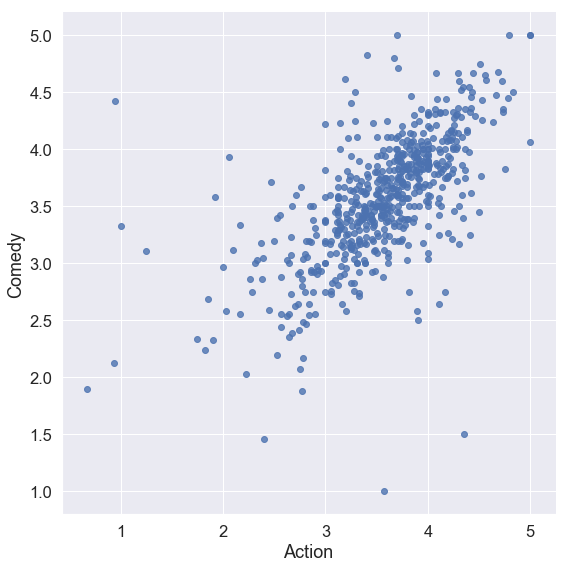

In [14]:
def get_genre_ratings(ratings, movies, genres, mean=True):
    all_genre_df = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre)]
        relevant_ratings = ratings[ratings['movieId'].isin(genre_movies['movieId'])]
        if mean is True:
            single_genre_df = relevant_ratings.groupby(['userId'])['rating'].mean().round(2)
        else:
            single_genre_df = relevant_ratings.groupby(['userId'])['rating'].count()
        all_genre_df = pd.concat([all_genre_df, single_genre_df], axis=1)
    all_genre_df.columns = genres
    return all_genre_df

genres = ['Action', 'Comedy']
users_by_avg_genre_ratings = get_genre_ratings(df_ratings, df_movies, genres)
sns.lmplot(genres[0], genres[1], data=users_by_avg_genre_ratings, fit_reg=False, height=8)
plt.show()

All genre ratings seem to be positively correlated. What's going on?

### Number of ratings
Let's try as features the total numbers of movies of each genre that users have rated.

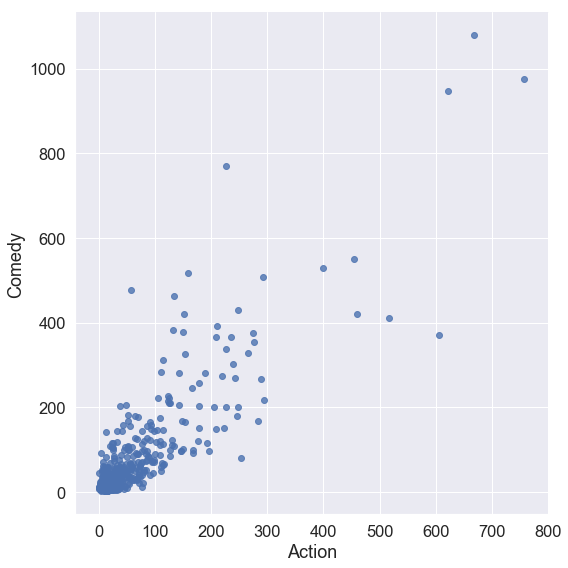

In [17]:
genres = ['Action', 'Comedy']
users_by_total_genre_ratings = get_genre_ratings(df_ratings, df_movies, genres, False)
sns.lmplot(genres[0], genres[1], data=users_by_total_genre_ratings, fit_reg=False, height=8)
plt.show()

Still everything seems correlated, why?

### Percentage of ratings
What if we instead define the feature vector as the percentage of ratings belonging to each genre?

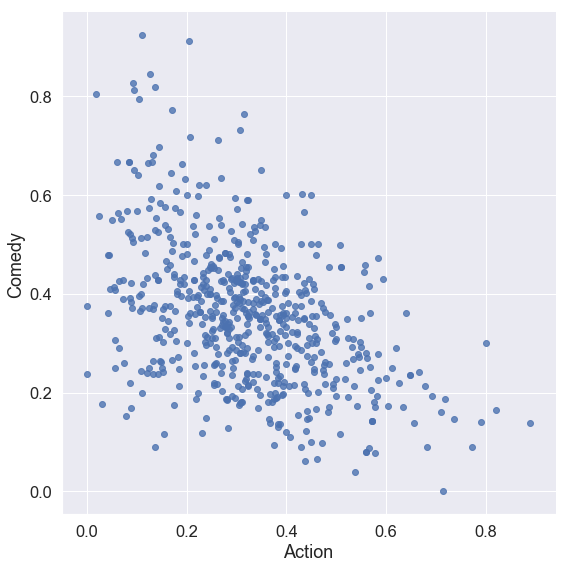

In [25]:
def get_genre_shares(ratings, movies):
    all_genres = np.unique(df_movies.genres.str.cat(sep="|").split("|"))
    all_genre_df = pd.DataFrame()
    for genre in all_genres:
        genre_movies = movies[movies['genres'].str.contains(genre)]
        relevant_ratings = ratings[ratings['movieId'].isin(genre_movies['movieId'])]
        single_genre_df = relevant_ratings.loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].count()
        all_genre_df = pd.concat([all_genre_df, single_genre_df], axis=1)
    # Get shares
    all_genre_df.columns = all_genres
    all_genre_df.fillna(0, inplace=True)
    all_genre_df = all_genre_df.div(ratings.groupby('userId').rating.count(), axis=0)
    return all_genre_df

genres = ['Action', 'Comedy']
users_by_rating_per = get_genre_shares(df_ratings, df_movies)
sns.lmplot(genres[0], genres[1], data=users_by_rating_per, fit_reg=False, height=8)
plt.show()

Now we see different correlations. Do you still see any issues with this representation?

## Similarity measures

Once we have objects described as data, we can compute the similarity between different objects. Each of the users is now described by their tastes for different genres. Let's keep the share of ratings representation for now.

In [27]:
users_by_rating_per.head()

Action  Adventure  Animation  Children    Comedy     Crime  Documentary  \
1  0.387931   0.366379   0.125000  0.181034  0.357759  0.193966     0.000000   
2  0.379310   0.103448   0.000000  0.000000  0.241379  0.344828     0.103448   
3  0.358974   0.282051   0.102564  0.128205  0.230769  0.051282     0.000000   
4  0.115741   0.134259   0.027778  0.046296  0.481481  0.125000     0.009259   
5  0.204545   0.181818   0.136364  0.204545  0.340909  0.272727     0.000000   

      Drama   Fantasy  Film-Noir    Horror      IMAX   Musical   Mystery   NA  \
1  0.293103  0.202586   0.004310  0.073276  0.000000  0.094828  0.077586  0.0   
2  0.586207  0.000000   0.000000  0.034483  0.137931  0.000000  0.068966  0.0   
3  0.410256  0.102564   0.000000  0.205128  0.000000  0.025641  0.025641  0.0   
4  0.555556  0.087963   0.018519  0.018519  0.004630  0.074074  0.106481  0.0   
5  0.568182  0.159091   0.000000  0.022727  0.068182  0.113636  0.022727  0.0   

    Romance    Sci-Fi  Thriller       War   Western  
1  0.112069  0.172414  0.237069  0.094828  0.030172  
2  0.034483  0.137931  0.344828  0.034483  0.034483  
3  0.128205  0.384615  0.179487  0.128205  0.000000  
4  0.268519  0.055556  0.175926  0.032407  0.046296  
5  0.250000  0.045455  0.204545  0.068182  0.045455

 So ... how can we tell if users have similar tastes? Generally, how can we compute similarity between users?  We've reduced this question to: how can we compute similarity between objects described as feature vectors.

There are many similarity measures.  Similarity is often cast as "closeness" in some space, as computed by a distance measure.  Often in data science, the terms similarity and distance are used interchangeably (a little strangely to the uninitiated). 

We'll use the library scipy.spatial.distance available [here](http://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

This library has functions to compute the distance between two numeric vectors. In particular, <br />
**pdist(X[, metric, p, w, V, VI])**	computes pairwise distances between the observations in n-dimensional space. 

_Metric parameter: The distance function can be ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’._

Here is a function that will compute the distance using as many metrics as you want:

In [35]:
def user_distance(users, userId, distance_measures, n):
    # We want a data frame to store the output
    # distance_measures is a list of the distance measures you want to compute (see below)
    # n is how many "most similar" to report
    distances = pd.DataFrame()
    
    # Find the location of the whiskey we are looking for # or index
    user_location = np.where(users.index == userId)[0][0]
    
    # Go through all distance measures we care about
    for distance_measure in distance_measures:
        # Find all pairwise distances
        current_distances = distance.squareform(distance.pdist(users, distance_measure))
        # Get the closest n elements for the user we care about
        most_similar = np.argsort(current_distances[:, user_location])[0:n]
        # Append results (a new column to the dataframe with the name of the measure)
        distances[distance_measure] = list(zip(users.index[most_similar], current_distances[most_similar, user_location]))
    return distances

We can use the function `user_distance` to find the distance value of each user with respect to others. We'll start using Euclidean distance as our metric:

In [36]:
user_distance(users_by_rating_per, 1, ['euclidean'], 6)

euclidean
0                    (1, 0.0)
1   (63, 0.17709559247252601)
2  (328, 0.18049125683427292)
3   (230, 0.1911339598809096)
4  (212, 0.19158200188198352)
5   (559, 0.1954084262054854)

Now, let's use more metrics.

In [37]:
user_distance(users_by_rating_per, 1, ['euclidean', 'cityblock', 'cosine', 'correlation'], 10)

euclidean                  cityblock  \
0                    (1, 0.0)                   (1, 0.0)   
1   (63, 0.17709559247252601)  (328, 0.5777045300878971)   
2  (328, 0.18049125683427292)  (212, 0.5998331479421579)   
3   (230, 0.1911339598809096)  (478, 0.6242163009404389)   
4  (212, 0.19158200188198352)   (63, 0.6383604784323705)   
5   (559, 0.1954084262054854)  (230, 0.6507380302654427)   
6  (478, 0.20577772020068938)  (308, 0.6938905547226386)   
7   (240, 0.2074993603640772)  (559, 0.6979064039408868)   
8  (382, 0.20955448226960666)   (217, 0.726099735613433)   
9   (592, 0.2127416253764623)  (171, 0.7265559293523969)   

                        cosine                 correlation  
0                     (1, 0.0)                    (1, 0.0)  
1    (63, 0.02007259654154714)   (63, 0.04716732663905232)  
2  (328, 0.020879378014717953)   (67, 0.04774478550878691)  
3   (230, 0.02286313548795038)  (559, 0.05127801917479913)  
4   (212, 0.02303528954305223)  (328, 0.05275220925130808)  
5  (559, 0.024611787474057678)  (212, 0.05312075731053223)  
6  (382, 0.026287795853424334)  (230, 0.05577719318647034)  
7  (478, 0.026535197553908874)  (382, 0.05859047293540853)  
8   (67, 0.026811159912045412)  (217, 0.06241298973945397)  
9   (394, 0.02808036514621126)  (592, 0.06264741383518524)

In [38]:
users_by_rating_per.loc[[1, 63, 328, 212]].sort_values(by=1, axis=1, ascending=False)

Action  Adventure    Comedy     Drama  Thriller   Fantasy     Crime  \
1    0.387931   0.366379  0.357759  0.293103  0.237069  0.202586  0.193966   
63   0.398524   0.328413  0.405904  0.350554  0.254613  0.140221  0.206642   
328  0.313725   0.360784  0.384314  0.341176  0.196078  0.207843  0.184314   
212  0.435484   0.350806  0.350806  0.375000  0.221774  0.177419  0.189516   

     Children    Sci-Fi  Animation   Romance       War   Musical   Mystery  \
1    0.181034  0.172414   0.125000  0.112069  0.094828  0.094828  0.077586   
63   0.110701  0.214022   0.121771  0.121771  0.059041  0.036900  0.077491   
328  0.235294  0.184314   0.200000  0.137255  0.047059  0.109804  0.070588   
212  0.120968  0.205645   0.145161  0.096774  0.040323  0.024194  0.076613   

       Horror   Western  Film-Noir        NA      IMAX  Documentary  
1    0.073276  0.030172   0.004310  0.000000  0.000000     0.000000  
63   0.044280  0.003690   0.018450  0.000000  0.077491     0.025830  
328  0.047059  0.027451   0.003922  0.000000  0.098039     0.003922  
212  0.056452  0.016129   0.004032  0.004032  0.112903     0.000000

## Clustering Methods

Similarity has many uses in data science.  One of the most commonly discussed is clustering: Can we find groups of users that are similar?

### Hierarchical Clustering

There are different ways to find similar groups.  One very common method is Hierarchical Clustering.

First let's look at a simple example to illustrate.  Given a set of records (A-F) with two features, we can visualize them on a 2 dimensional surface.  Clustering proceeds as follows.  First consider each point to be its own cluster.  Then, iteratively, group together the closest two clusters.  In the figure, circles were drawn in order of grouping.  The second diagram is a visualization of the hierarchy of groupings, called a "dendrogram."  You can clip it at any point, vertically, and get "the best" clustering for a certain number of groups.


<img src="images/cutting.png" height=40% width=40%>

Let's examine the dendrogram(s) for our data, we'll be using the library: **scipy.cluster.hierarchy**

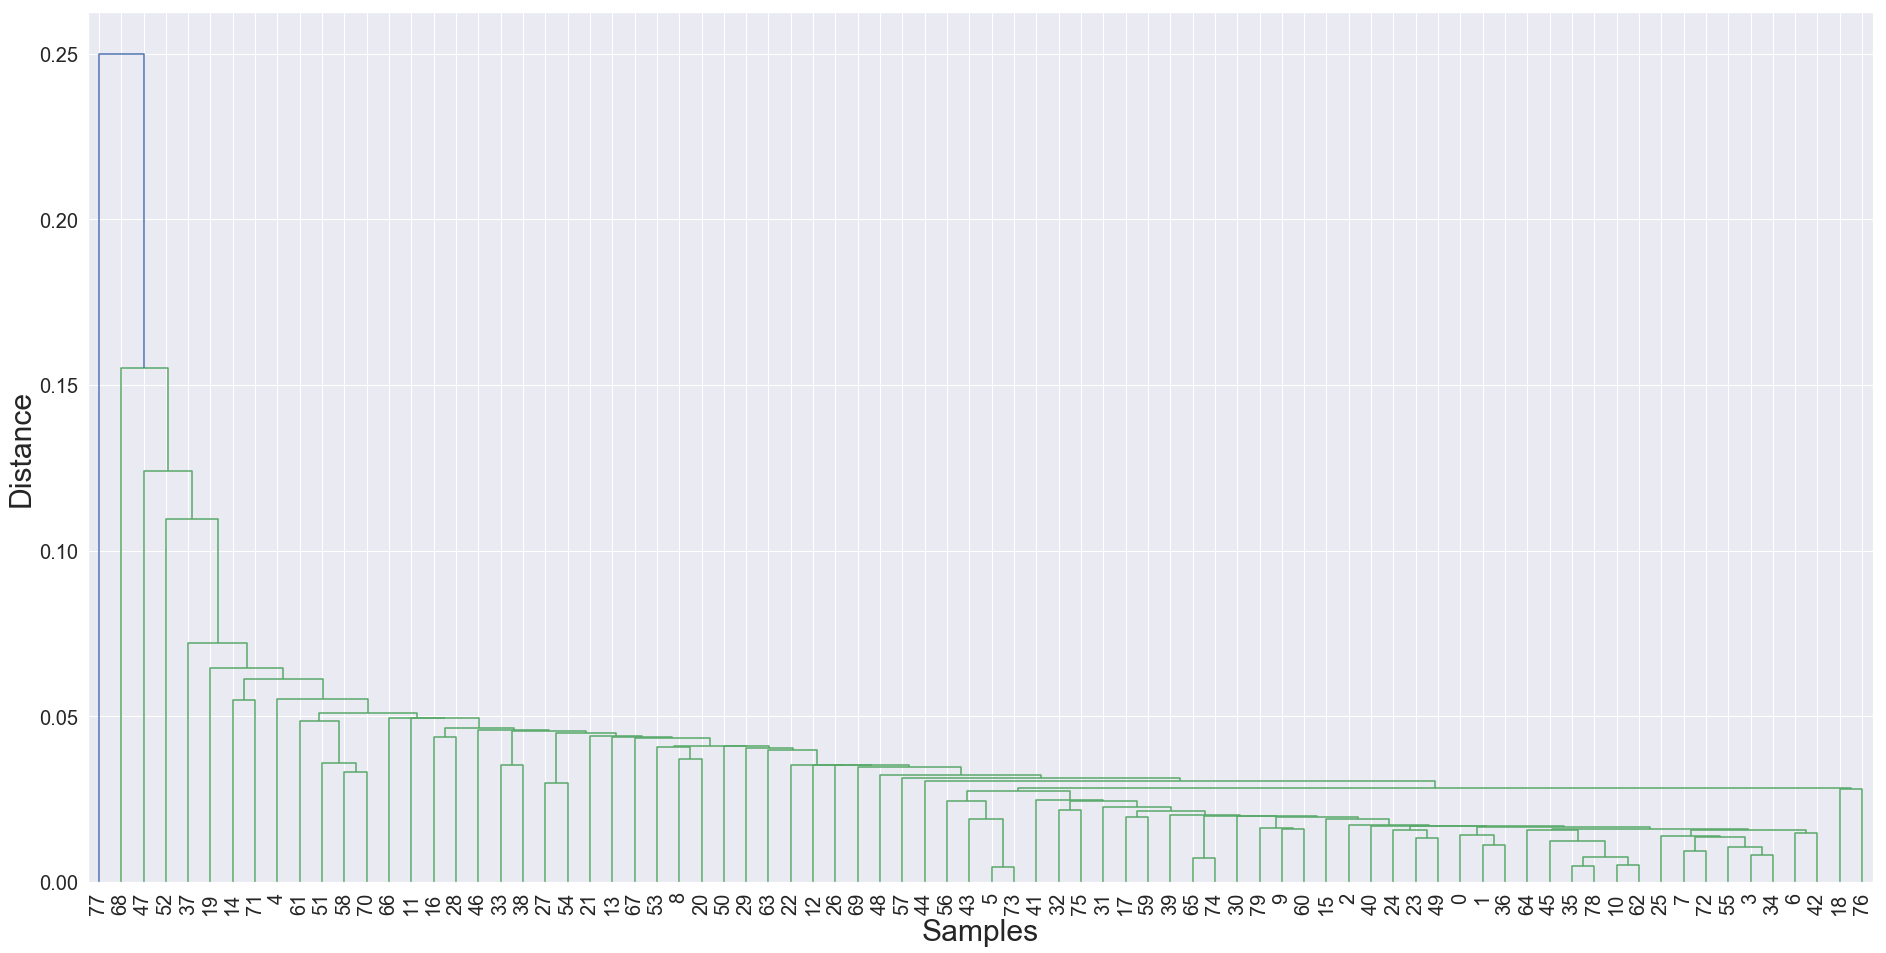

In [51]:
sample = users_by_rating_per.sample(80, random_state=42)

# This function gets pairwise distances between observations in n-dimensional space (e.g., cosine, euclidean).
dists = distance.pdist(sample, metric="cosine")

# This scipy's function performs hierarchical/agglomerative clustering on the condensed distance matrix y.
# Method could be 'average' distance from points in cluster v to points in cluster w or the 'single' shortest distance
links = linkage(dists, method='single')

# Now we want to plot those 'links' using "dendrogram" function
plt.rcParams['figure.figsize'] = 32, 16

den = dendrogram(links)

plt.xlabel('Samples',fontsize=30)
plt.ylabel('Distance',fontsize=30)
plt.xticks(rotation=90,fontsize=20)
plt.yticks(fontsize=20)
plt.show()

It is common to cut dendrograms at a particular height and to then use the resulting clusters. However, watch out for two things when doing hierarchical clusters: (1) it does not scale well with large data sets and (2) it's very sensitive to outliers.

### KMeans

Another method for finding clusters is to use the KMeans algorithm to find a set of $k$ clusters. Here, unlike in hierarchical clustering, we define the number of clusters in advance. We'll use the library **sklearn.cluster**

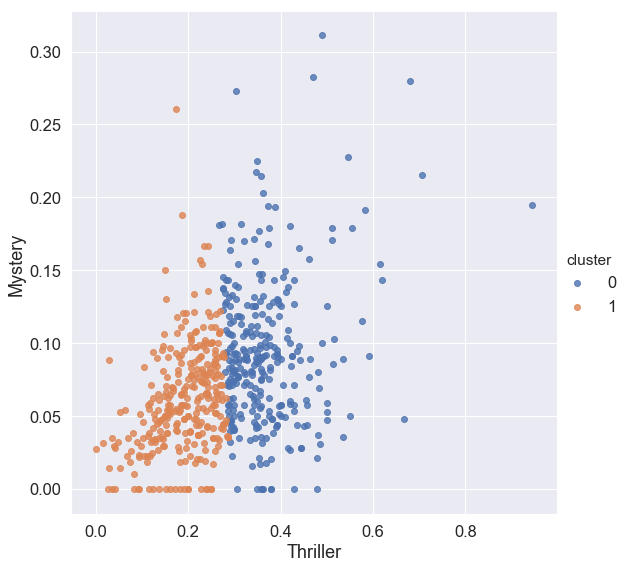

In [60]:
k_clusters = 2
kmeans = KMeans(n_clusters=k_clusters, random_state=42)
genres = ['Thriller', 'Mystery']
kmeans.fit(users_by_rating_per[genres])
users_by_rating_per['cluster'] = kmeans.predict(users_by_rating_per[genres])
sns.lmplot(genres[0], genres[1], data=users_by_rating_per, hue='cluster', fit_reg=False, height=8)
plt.show()

We are using euclidean distance to find these clusters. Do you have any concerns about this?

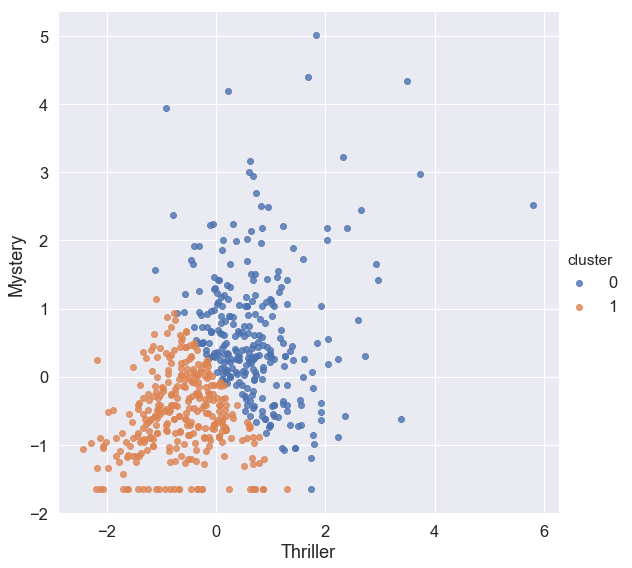

In [53]:
df_normalized_genre = (users_by_rating_per - users_by_rating_per.mean())/users_by_rating_per.std()
k_clusters = 2
kmeans = KMeans(n_clusters=k_clusters, random_state=42)
genres = ['Thriller', 'Mystery']
kmeans.fit(df_normalized_genre[genres])
df_normalized_genre['cluster'] = kmeans.predict(df_normalized_genre[genres])
sns.lmplot(genres[0], genres[1], data=df_normalized_genre, hue='cluster', fit_reg=False, height=8)
plt.show()

KMeans is very sensitive to scale and will tend to cluster according to the features with greater variance.

What happens if we use all the genres to cluster users?

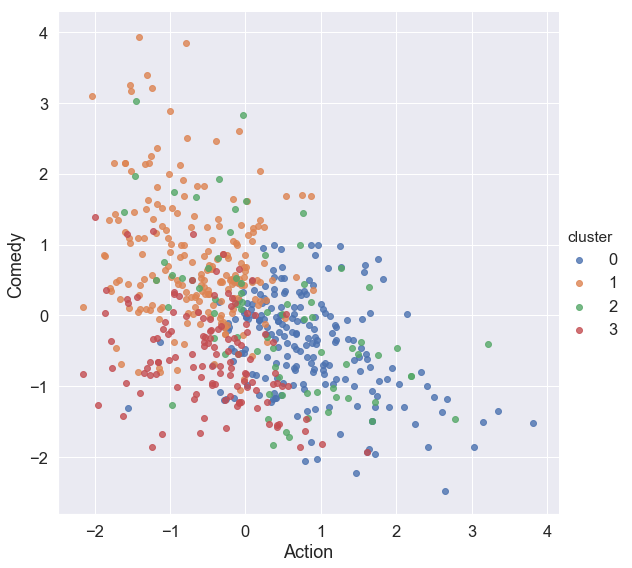

In [72]:
kmeans = KMeans(n_clusters=4, random_state=42)
all_genres = df_normalized_genre.columns[df_normalized_genre.columns != 'cluster']
genres = ['Action', 'Comedy']
df_normalized_genre['cluster'] = kmeans.fit_predict(df_normalized_genre[all_genres]).astype(int)
sns.lmplot(genres[0], genres[1], data=df_normalized_genre, hue='cluster', fit_reg=False, height=8)
plt.show()

Then, how can we describe or name each cluster?

In [73]:
centroids = df_normalized_genre.groupby('cluster').mean()
centroids

Action  Adventure  Animation  Children    Comedy     Crime  \
cluster                                                                 
0        0.809631   0.456467  -0.225293 -0.252593 -0.427190  0.175987   
1       -0.667431  -0.499254  -0.074904  0.093036  0.785591 -0.470777   
2        0.372624   1.429450   1.732187  1.550481 -0.026760 -0.728362   
3       -0.480415  -0.802791  -0.544583 -0.663086 -0.552317  0.910126   

         Documentary     Drama   Fantasy  Film-Noir    Horror      IMAX  \
cluster                                                                   
0          -0.222671 -0.391321 -0.122523  -0.210109  0.295830  0.085495   
1          -0.053575  0.043593 -0.088222  -0.204869 -0.129848 -0.379723   
2          -0.087290 -0.757631  1.526812  -0.361587 -0.300447  1.233195   
3           0.508123  1.031812 -0.569916   0.897600 -0.098753 -0.264828   

          Musical   Mystery        NA   Romance    Sci-Fi  Thriller       War  \
cluster                                                                         
0       -0.270579 -0.052389 -0.107336 -0.557005  0.636107  0.637430  0.090150   
1        0.395025 -0.442646 -0.089127  0.821813 -0.552026 -0.596973 -0.245002   
2        0.572740 -0.261637  0.751787 -0.281135  0.568871 -0.773184 -0.262062   
3       -0.537086  0.962596 -0.128581 -0.243542 -0.498226  0.377809  0.405831   

          Western  
cluster            
0        0.081590  
1        0.093132  
2       -0.408433  
3       -0.041300

In [74]:
data = defaultdict(list)
top = 3

clusters = sorted(df_normalized_genre.cluster.unique())
for cluster in clusters:
    tastes = centroids.loc[cluster].sort_values()
    for i, t in enumerate(tastes[:top].index):
        data["Dislike {0}".format(i + 1)].append("{0}: {1}".format(t, tastes[t].round(2)))
    for i, t in enumerate(tastes[-top:][::-1].index):
        data["Like {0}".format(i + 1)].append("{0}: {1}".format(t, tastes[t].round(2)))
    counts = df_normalized_genre[df_normalized_genre.cluster == cluster].shape[0]
    data["count"].append(counts)
    
cols = ['count'] + ["Like {0}".format(i+1) for i in range(top)] + ["Dislike {0}".format(i+1) for i in range(top)]
cluster_info = pd.DataFrame(data)[cols].transpose()
cluster_info.columns = ["cluster {0}".format(i) for i in clusters]
cluster_info

cluster 0       cluster 1        cluster 2        cluster 3
count                 207             203               75              125
Like 1       Action: 0.81   Romance: 0.82  Animation: 1.73      Drama: 1.03
Like 2     Thriller: 0.64    Comedy: 0.79   Children: 1.55    Mystery: 0.96
Like 3       Sci-Fi: 0.64    Musical: 0.4    Fantasy: 1.53      Crime: 0.91
Dislike 1  Romance: -0.56   Action: -0.67  Thriller: -0.77  Adventure: -0.8
Dislike 2   Comedy: -0.43  Thriller: -0.6     Drama: -0.76  Children: -0.66
Dislike 3    Drama: -0.39   Sci-Fi: -0.55     Crime: -0.73   Fantasy: -0.57

We could think of these as the "Unexpected Action", "Happy Films", "Cartoon Adventure", and "Sinister Drama" clusters. Perhaps we could use this information to develop four new films that would cover a wide variety of tastes. 

## Movie-level Clustering
Now that we've covered some ground regarding how Kmeans clusters users based on their genre tastes, let's take a bigger bite and look at how users rated individual movies. To do that, we'll shape the dataset in the form of userId vs user rating for each movie. For example, let's look at a subset of the dataset:

In [75]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(df_ratings, df_movies[['movieId', 'title']], on='movieId')
df_user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

print('dataset dimensions: ', df_user_movie_ratings.shape, '\n\nSubset example:')
df_user_movie_ratings.iloc[10:20, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title   '71 (2014)  'Hellboy': The Seeds of Creation (2004)  \
userId                                                        
11             NaN                                      NaN   
12             NaN                                      NaN   
13             NaN                                      NaN   
14             NaN                                      NaN   
15             NaN                                      NaN   
16             NaN                                      NaN   
17             NaN                                      NaN   
18             NaN                                      NaN   
19             NaN                                      NaN   
20             NaN                                      NaN   

title   'Round Midnight (1986)  'Salem's Lot (2004)  \
userId                                                
11                         NaN                  NaN   
12                         NaN                  NaN   
13                         NaN                  NaN   
14                         NaN                  NaN   
15                         NaN                  NaN   
16                         NaN                  NaN   
17                         NaN                  NaN   
18                         NaN                  NaN   
19                         NaN                  NaN   
20                         NaN                  NaN   

title   'Til There Was You (1997)  'Tis the Season for Love (2015)  \
userId                                                               
11                            NaN                              NaN   
12                            NaN                              NaN   
13                            NaN                              NaN   
14                            NaN                              NaN   
15                            NaN                              NaN   
16                            NaN                              NaN   
17                            NaN                              NaN   
18                            NaN                              NaN   
19                            NaN                              NaN   
20                            NaN                              NaN   

title   'burbs, The (1989)  'night Mother (1986)  (500) Days of Summer (2009)  \
userId                                                                          
11                     NaN                   NaN                          NaN   
12                     5.0                   NaN                          NaN   
13                     NaN                   NaN                          NaN   
14                     NaN                   NaN                          NaN   
15                     NaN                   NaN                          4.0   
16                     NaN                   NaN                          NaN   
17                     NaN                   NaN                          NaN   
18                     NaN                   NaN                          4.0   
19                     2.0                   NaN                          NaN   
20                     NaN                   NaN                          NaN   

title   *batteries not included (1987)  
userId                                  
11                                 NaN  
12                                 NaN  
13                                 NaN  
14                                 NaN  
15                                 NaN  
16                                 NaN  
17                                 NaN  
18                                 NaN  
19                                 NaN  
20                                 NaN

Most users have not rated and watched most movies. The dominance of NaN values can be an important issue. Can you tell why?

Same as with text, datasets like this are called "sparse" because only a small number of cells have values. To get around this, let's sort by the most rated movies, and the users who have rated the most number of movies. That will present a more 'dense' region when we peak at the top of the dataset.

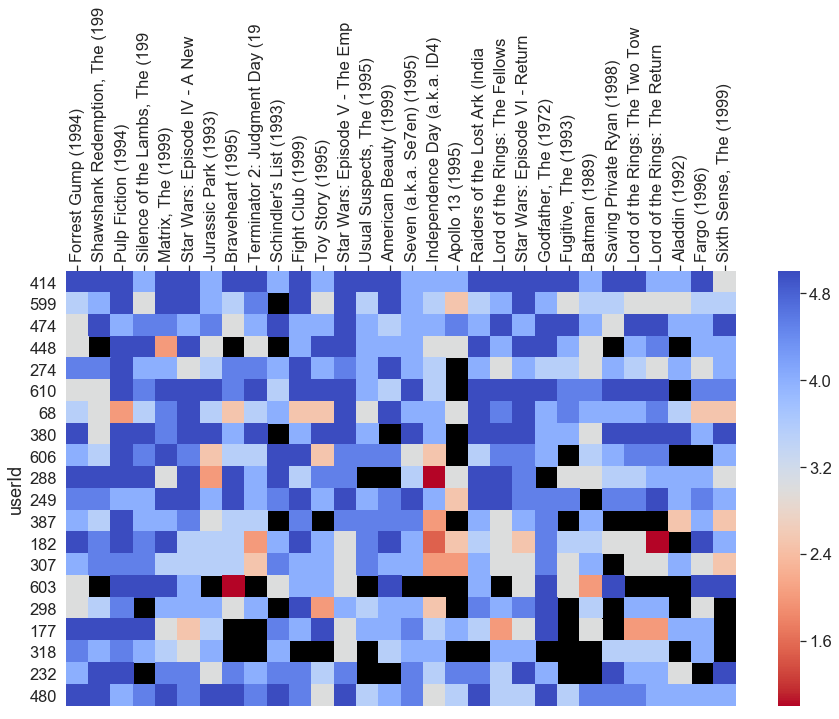

In [76]:
n_movies = 30
n_users = 20
top_movies = df_user_movie_ratings.count().sort_values()[-n_movies:].index[::-1]
top_users = df_user_movie_ratings.count(axis=1).sort_values()[-n_users:].index[::-1]
top_mat = df_user_movie_ratings.loc[top_users, top_movies]
plt.figure(figsize = (15,8))
shorter_titles = [c[:30] for c in top_mat.columns]
g = sns.heatmap(top_mat, cmap=plt.cm.coolwarm_r, xticklabels=shorter_titles)
g.xaxis.set_ticks_position('top')
plt.setp(g.get_xticklabels(), rotation=90)
plt.xlabel('')
g.set_facecolor('black')
plt.show()

Each column is a movie. Each row is a user. The color of the cell is how the user rated that movie based on the scale on the right of the graph.

Notice how some cells are black? This means the respective user did not rate that movie. This is an issue you'll come across when clustering in real life. Unlike the clean example we started with, real-world datasets can often be sparse and not have a value in each cell of the dataset. This makes it less straightforward to cluster users directly by their movie ratings as k-means generally does not like missing values. Can you think what to do about it?

In [77]:
# We will keep the top 1000 movies to cluster people
n_movies = 1000
top_movieId = ratings_title.movieId.value_counts()[:1000].index
ratings_top_movies = ratings_title[np.in1d(ratings_title.movieId, top_movieId)]

# Create a sparse version of the Users X Movies dataframe. This will impute a value of 0 for missing data.
titles_c = np.array(sorted(ratings_top_movies.title.unique()))
users_c = np.array(sorted(ratings_top_movies.userId.unique()))
row = pd.Categorical(ratings_top_movies.userId, categories=users_c, ordered=True).codes
col = pd.Categorical(ratings_top_movies.title, categories=titles_c, ordered=True).codes
sparse_ratings = csr_matrix((ratings_top_movies.rating, (row, col)), shape=(users_c.size, titles_c.size))
sparse_ratings

<610x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 61256 stored elements in Compressed Sparse Row format>

Let's cluster by movies and take a look at the results! 

In [78]:
k_clusters = 20
kmeans = KMeans(n_clusters=k_clusters, random_state=42)
clusters = kmeans.fit_predict(sparse_ratings).astype(int)

data = defaultdict(list)
top = 5
for cluster in range(k_clusters):
    top_ixs = np.asarray(sparse_ratings[clusters == cluster, :].mean(axis=0).argsort()[0, -top:]).reshape(-1)
    for i, ix in enumerate(top_ixs):
        data["Top {0} Movie".format(i + 1)].append(titles_c[ix])
    counts = clusters[clusters == cluster].size
    data["count"].append(counts)
    
cols = ['count'] + ["Top {0} Movie".format(i+1) for i in range(top)]
cluster_info = pd.DataFrame(data)[cols].transpose()
cluster_info.columns = ["cluster {0}".format(i) for i in range(k_clusters)]
cluster_info.iloc[:, cluster_info.loc['count'].argsort()[::-1]]

cluster 11             cluster 6  \
count                                     216                    86   
Top 1 Movie                 Fight Club (1999)      Apollo 13 (1995)   
Top 2 Movie           Schindler's List (1993)   Pulp Fiction (1994)   
Top 3 Movie                Matrix, The (1999)     Braveheart (1995)   
Top 4 Movie               Forrest Gump (1994)   Forrest Gump (1994)   
Top 5 Movie  Shawshank Redemption, The (1994)  Fugitive, The (1993)   

                                   cluster 18  \
count                                      78   
Top 1 Movie  Silence of the Lambs, The (1991)   
Top 2 Movie                Matrix, The (1999)   
Top 3 Movie  Shawshank Redemption, The (1994)   
Top 4 Movie               Pulp Fiction (1994)   
Top 5 Movie                 Fight Club (1999)   

                                                     cluster 4  \
count                                                       51   
Top 1 Movie  Star Wars: Episode VI - Return of the Jedi (1983)   
Top 2 Movie                  Terminator 2: Judgment Day (1991)   
Top 3 Movie                                 Matrix, The (1999)   
Top 4 Movie          Star Wars: Episode IV - A New Hope (1977)   
Top 5 Movie  Star Wars: Episode V - The Empire Strikes Back...   

                                                    cluster 10  \
count                                                       43   
Top 1 Movie                   Shawshank Redemption, The (1994)   
Top 2 Movie  Lord of the Rings: The Fellowship of the Ring,...   
Top 3 Movie      Lord of the Rings: The Two Towers, The (2002)   
Top 4 Movie                                 Matrix, The (1999)   
Top 5 Movie  Lord of the Rings: The Return of the King, The...   

                                            cluster 13  \
count                                               28   
Top 1 Movie  Twelve Monkeys (a.k.a. 12 Monkeys) (1995)   
Top 2 Movie                 Mission: Impossible (1996)   
Top 3 Movie                             Twister (1996)   
Top 4 Movie                           Toy Story (1995)   
Top 5 Movie       Independence Day (a.k.a. ID4) (1996)   

                                                     cluster 1  \
count                                                       21   
Top 1 Movie                             Terminator, The (1984)   
Top 2 Movie  Star Wars: Episode VI - Return of the Jedi (1983)   
Top 3 Movie                  Terminator 2: Judgment Day (1991)   
Top 4 Movie          Star Wars: Episode IV - A New Hope (1977)   
Top 5 Movie  Star Wars: Episode V - The Empire Strikes Back...   

                                          cluster 2  \
count                                            17   
Top 1 Movie                 Some Like It Hot (1959)   
Top 2 Movie        Silence of the Lambs, The (1991)   
Top 3 Movie                            Fargo (1996)   
Top 4 Movie  Monty Python and the Holy Grail (1975)   
Top 5 Movie                       Casablanca (1942)   

                                                     cluster 7  \
count                                                       15   
Top 1 Movie                                Forrest Gump (1994)   
Top 2 Movie  Star Wars: Episode VI - Return of the Jedi (1983)   
Top 3 Movie                                 Matrix, The (1999)   
Top 4 Movie          Star Wars: Episode IV - A New Hope (1977)   
Top 5 Movie  Star Wars: Episode V - The Empire Strikes Back...   

                                   cluster 12  \
count                                      12   
Top 1 Movie  Silence of the Lambs, The (1991)   
Top 2 Movie          Wizard of Oz, The (1939)   
Top 3 Movie              Groundhog Day (1993)   
Top 4 Movie               Pulp Fiction (1994)   
Top 5 Movie             Godfather, The (1972)   

                                                     cluster 0  \
count                                                       11   
Top 1 Movie                               Groundhog Day (1993)   
Top 2 

We can see some clear trends in the clusters. For example: 
* Cluster 18 likes crime movies
* Clusters 4 and 1 like Star Wars and Terminator.
* Cluster 10 likes Lord of the Rings.

Can you think of other ways to represent users and cluster them?

## Nearest Neighbors: Recommending Movies

Imagine that we want to make movie recommendations to a user. Can we use similarity to do this? As an example, let's find the previously learnt classification technique, nearest neighbors. to userId 1.

In [79]:
# Find k=10 nearest neighbors
k = 10
nn_model = NearestNeighbors(n_neighbors=k+1).fit(sparse_ratings)
distances, indices = nn_model.kneighbors(sparse_ratings[0,:])

Now, let's find the movies that were liked the most by taking the average rating. Do you think this is a good idea? Why yes or why not?

In [80]:
# Get average ratings for each movie according to nearest neighbors
avg_ratings = np.asarray(sparse_ratings[indices[0, 1:], :].mean(axis=0)).reshape(-1)

# Get top recommendations
k_rec = 10
top_recommendations = titles_c[avg_ratings.argsort()[::-1][:k_rec]]

# Check  whether the user has already seen these movies.
for title in top_recommendations:
    user_rating = df_user_movie_ratings.loc[1, title]
    if  pd.isnull(user_rating):
        print("RECOMMEND:", title)
    else:
        print("USER GAVE RATING", user_rating, "TO",  title)

RECOMMEND: Terminator 2: Judgment Day (1991)
RECOMMEND: Godfather, The (1972)
USER GAVE RATING 5.0 TO Matrix, The (1999)
USER GAVE RATING 4.0 TO Braveheart (1995)
RECOMMEND: Aliens (1986)
USER GAVE RATING 5.0 TO Star Wars: Episode VI - Return of the Jedi (1983)
USER GAVE RATING 5.0 TO Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
USER GAVE RATING 5.0 TO Star Wars: Episode IV - A New Hope (1977)
USER GAVE RATING 5.0 TO Indiana Jones and the Last Crusade (1989)
USER GAVE RATING 4.0 TO Saving Private Ryan (1998)


The nearest neighbors like Terminator 2. What if we wanted to predict how much the user would like this recommendation? How could we do that?

That's a supervised learning task. If we have a target variable to estimate/predict and labels for a training set,  we can do prediction directly using similarity.

In this case, our label would be the rating for the Terminator 2 movie. One way to use similarity to build a predictor<sup>&dagger;</sup> is to use a **Nearest Neighbor algorithm**.  The idea is: to predict the value of the target variable for a data item, first find the most similar (closest) training data items.  The **k-Nearest-Neighbor** or **kNN** algorithm chooses the closest `k` data points.  Then, gather the values of the target variable for them, and then combine them somehow.  So, to classify, one might combine them by having them vote their classes. (How would you combine to compute probability estimates? What about a regression problem?)

For now, let's take a look at the ratings of the top recommended movies for each nearest neighbor.

<sup>&dagger;</sup>There's an interesting question as to whether we're actually building a *model* here.

In [81]:
top_neighbors_movies = df_user_movie_ratings.iloc[indices[0, 1:]][top_recommendations] 
top_neighbors_movies

title   Terminator 2: Judgment Day (1991)  Godfather, The (1972)  \
userId                                                             
493                                   4.0                    5.0   
39                                    4.0                    4.0   
577                                   NaN                    5.0   
368                                   3.0                    5.0   
96                                    5.0                    4.0   
164                                   5.0                    NaN   
532                                   4.0                    5.0   
79                                    5.0                    5.0   
208                                   4.0                    NaN   
72                                    4.5                    4.5   

title   Matrix, The (1999)  Braveheart (1995)  Aliens (1986)  \
userId                                                         
493                    5.0                5.0            4.0   
39                     5.0                NaN            5.0   
577                    NaN                4.0            3.0   
368                    4.0                4.0            5.0   
96                     4.0                5.0            5.0   
164                    NaN                5.0            5.0   
532                    5.0                5.0            5.0   
79                     4.0                NaN            4.0   
208                    5.0                4.0            NaN   
72                     5.0                4.5            NaN   

title   Star Wars: Episode VI - Return of the Jedi (1983)  \
userId                                                      
493                                                   NaN   
39                                                    5.0   
577                                                   4.0   
368                                                   4.0   
96                                                    5.0   
164                                                   4.0   
532                                                   NaN   
79                                                    5.0   
208                                                   4.0   
72                                                    4.5   

title   Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)  \
userId                                                                                   
493                                                   4.0                                
39                                                    4.0                                
577                                                   4.0                                
368                                                   4.0                                
96                                                    5.0                                
164                                                   5.0                                
532                                                   4.0                                
79                                                    NaN                                
208                                                   NaN                                
72                                                    4.5                                

title   Star Wars: Episode IV - A New Hope (1977)  \
userId                                              
493                                           5.0   
39                                            5.0   
577                                           5.0   
368                                           4.0   
96                                            5.0   
164                                           NaN   
532                                           NaN   
79                                            5.0   
208                                           NaN   
72               

Let's take the average rating now (excluding people that did not rate the movie) and compare that to the user ratings.

In [82]:
df_rec = pd.concat([top_neighbors_movies.mean(), df_user_movie_ratings.loc[1, top_recommendations]], axis=1)
df_rec.columns = ['Avg. Rating', 'UserId 1 Ratings']
df_rec

Avg. Rating  \
title                                                             
Terminator 2: Judgment Day (1991)                      4.277778   
Godfather, The (1972)                                  4.687500   
Matrix, The (1999)                                     4.625000   
Braveheart (1995)                                      4.562500   
Aliens (1986)                                          4.500000   
Star Wars: Episode VI - Return of the Jedi (1983)      4.437500   
Raiders of the Lost Ark (Indiana Jones and the ...     4.312500   
Star Wars: Episode IV - A New Hope (1977)              4.857143   
Indiana Jones and the Last Crusade (1989)              4.125000   
Saving Private Ryan (1998)                             4.714286   

                                                    UserId 1 Ratings  
title                                                                 
Terminator 2: Judgment Day (1991)                                NaN  
Godfather, The (1972)                                            NaN  
Matrix, The (1999)                                               5.0  
Braveheart (1995)                                                4.0  
Aliens (1986)                                                    NaN  
Star Wars: Episode VI - Return of the Jedi (1983)                5.0  
Raiders of the Lost Ark (Indiana Jones and the ...               5.0  
Star Wars: Episode IV - A New Hope (1977)                        5.0  
Indiana Jones and the Last Crusade (1989)                        5.0  
Saving Private Ryan (1998)                                       4.0

Seems like Terminator might not be the best recommendation after all! But how come it was listed as the top recommendation? What would you do differently?

### Finding similar movies

Suppose we recommend 'Aliens' to userId 1, and the user loves the movie. He asks us to recommend a movie similar to that one. How would you do that? HINT: It's pretty much the same thing we already did.

In [83]:
movie = "Aliens (1986)"
movie_ix = np.where(movie == titles_c)[0][0]
# Find k=10 nearest movies
k = 10
nn_model = NearestNeighbors(n_neighbors=k+1).fit(sparse_ratings.T)
distances, indices = nn_model.kneighbors(sparse_ratings.T[movie_ix,:])
titles_c[indices[0]]

array(['Aliens (1986)', 'Alien (1979)', 'Predator (1987)',
       'RoboCop (1987)', 'Terminator, The (1984)', 'Total Recall (1990)',
       'Abyss, The (1989)', 'Superman (1978)', 'Mad Max (1979)',
       'Road Warrior, The (Mad Max 2) (1981)',
       'Escape from New York (1981)'], dtype='<U94')

### Prediction via similarity

In a previous example we decided to predict ratings based on the 10 nearest neighbors. But why not just the nearest neighbor? Or why not the 100 nearest neighbors? To illustrate this, let's go back to our earlier example of describing users in terms of the genres they like. 

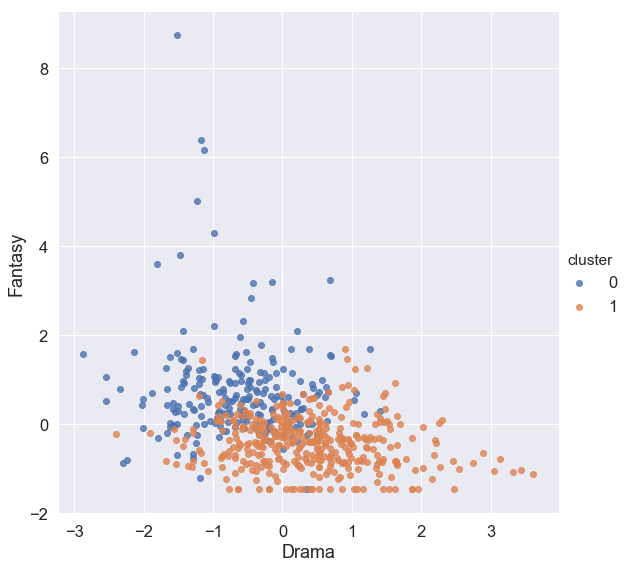

In [84]:
kmeans = KMeans(n_clusters=2, random_state=42)
all_genres = df_normalized_genre.columns[df_normalized_genre.columns != 'cluster']
genres = ['Drama', 'Fantasy']
df_normalized_genre['cluster'] = kmeans.fit_predict(df_normalized_genre[all_genres]).astype(int)
sns.lmplot(genres[0], genres[1], data=df_normalized_genre, hue='cluster', fit_reg=False, height=8)
plt.show()

Suppose we want to find to which cluster each user belongs based only on their taste for fantasy and drama. How would the decision surface look like?

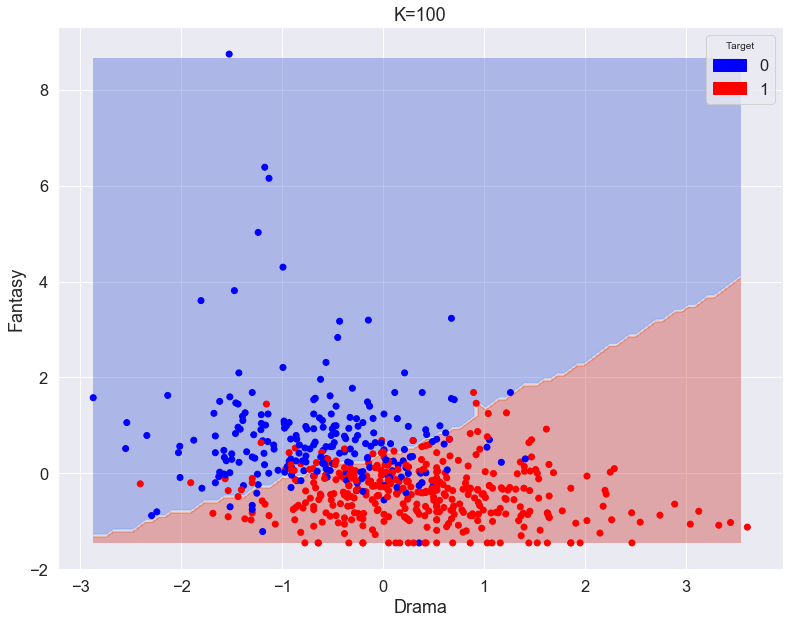

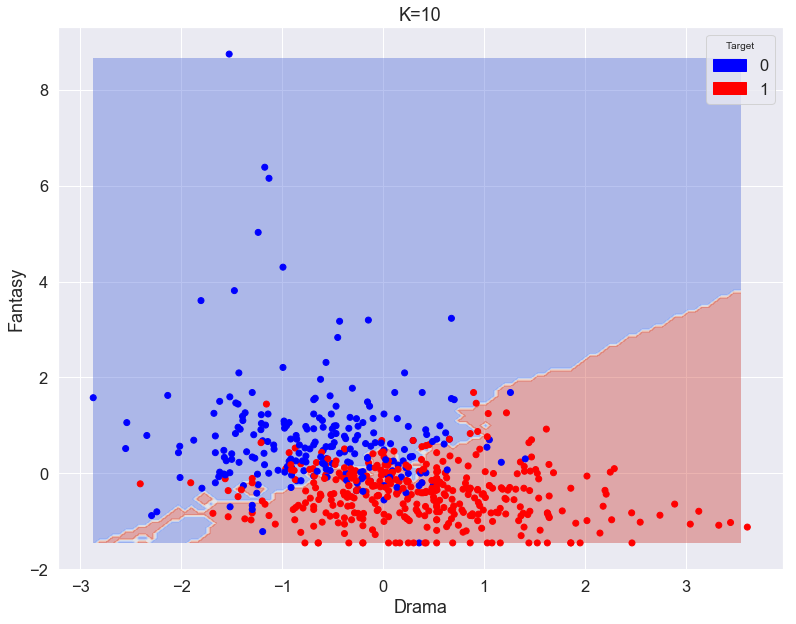

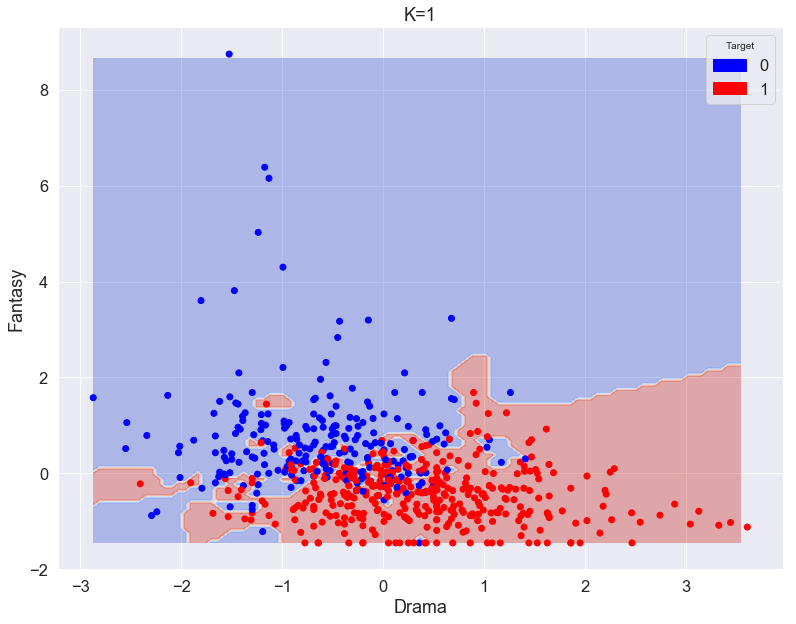

In [85]:
# Let's start by slitting the data
from sklearn.model_selection import train_test_split
X = df_normalized_genre[genres]
Y = df_normalized_genre['cluster']

for i, k in enumerate([100, 10, 1]):
    plt.figure(figsize=[13,10])
    model = KNeighborsClassifier(n_neighbors=k)
    Decision_Surface(X, genres[0], genres[1], Y, model)
    plt.title("K=" + str(k))
    plt.show()

Does this look familiar? How should we determine which K is the best one? You guessed it, in the same way we find optimal complexity control parameters.

In [86]:
for k in [1, 10, 20, 50, 100, 200, 400]:
    model = KNeighborsClassifier(n_neighbors=k)
    auc = cross_val_score(model, X, Y, scoring="roc_auc", cv=10).mean()
    print("AUC: {0} with K {1}".format(round(auc*100, 2), k))

AUC: 78.39 with K 1
AUC: 89.92 with K 10
AUC: 91.35 with K 20
AUC: 92.46 with K 50
AUC: 92.76 with K 100
AUC: 92.34 with K 200
AUC: 91.49 with K 400
